In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [162]:
def make_random_field(nLat, nSamp, *, cut=0.5, ns=-1):
    nn = nLat//2 + 1
    
    fk = np.random.normal(size=(nSamp,nn)) + 1j*np.random.normal(size=(nSamp,nn))
    fk[:,0] = 0.
    fk[:,-1] = 0.
    fk[:,int(cut*nn):] = 0.
    
    kv = np.fft.rfftfreq(nLat)
    fk[:,1:] = fk[:,1:]*np.sqrt(kv[1:])**ns
    
    return np.fft.irfft(fk, n=nLat, axis=-1)


In [227]:
num_samp = 10000
nLat = 256

fns = make_random_field(nLat, num_samp)


In [228]:
fk = np.fft.rfft(fns,axis=-1)
pk = np.mean(np.abs(fk)**2,axis=0)

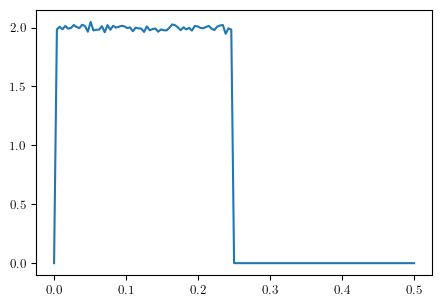

In [229]:
kv = np.fft.rfftfreq(fns.shape[-1])
plt.plot(kv,kv*pk)

In [233]:
sig = np.mean(np.std(fns,axis=-1))
print(sig)

0.26924325967104035


In [250]:
alpha = 1.
var = np.mean(fns**2)

f_nl = lambda x,a,s2 : x + a*(x**2-s2)

f_ng = fns + alpha*(fns**2 - np.mean(fns**2))
fk_ng = np.fft.rfft(f_ng,axis=-1)
pk_ng = np.mean(np.abs(fk_ng)**2,axis=0)

Text(0, 0.5, '$f_{\\rm NL}$')

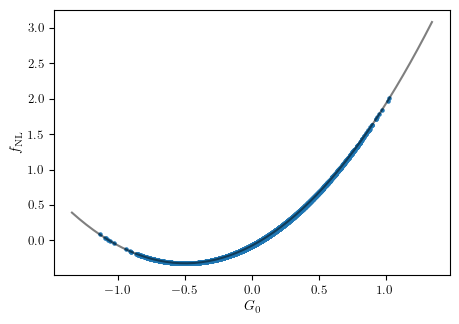

In [245]:
xv = np.linspace(-5.*sig,5.*sig,51)
plt.plot(xv, f_nl(xv,alpha,var),'k', alpha=0.5)

plt.scatter(fns[:100],f_ng[:100], s=5.)
plt.xlabel(r'$G_0$')
plt.ylabel(r'$f_{\rm NL}$')

Now let's see what happens when we compare to an underlying field different from the Gaussian used to map.
We'll do a few different things, including:
 1. Changing the spectral tilt
 2. Prewhitening using the final (nonGaussian) spectrum
 3. Putting some features in the spectrum
 
For now we'll assume our initial spectrum is generated from a scale invariant (in 1D) power spectrum as above.
However, after this preliminary investigation, we'll also do some inverse approximation.

**TBD** : Figure out what the correct normalisation on the spectrum is to compare perturbations

In [246]:
def tilt_spectrum(f, ns):
    nLat = f.shape[-1]
    fk = np.fft.rfft(f, axis=-1)

    kv = np.fft.rfftfreq(nLat)
    fk[:,1:] = fk[:,1:] * np.sqrt(kv[1:])**ns
    
    return np.fft.irfft(fk, n=nLat, axis=-1)


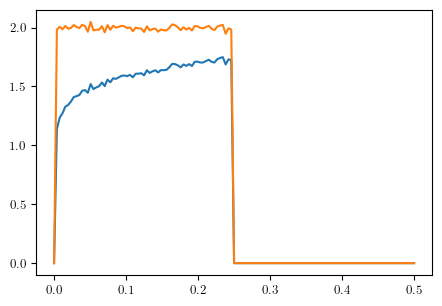

In [247]:
f_tilt = tilt_spectrum(fns,0.1)
fk_tilt = np.fft.rfft(f_tilt)
plt.plot(kv,kv*np.mean(np.abs(fk_tilt)**2,axis=0))
plt.plot(kv,kv*np.mean(np.abs(fk)**2,axis=0))


## Comparing to a modified underlying field
We have defined our nonlinear field

$$ \hat{f}_{\rm NL}(x) = \hat{G}_0(x) + 0.05 \frac{\hat{G}_0^2(x)}{\sigma^2} $$

where $\sigma^2$ is the ensemble-averaged real-space variance of the field $G_0$.  Therefore, if we make a pointwise comparison between $f_{\rm NL}$ and $G_0$, we obtain a perfectly "correlated" relationship with no scatter.

From our experience with simulating early Universe dynamics, it seems as though Gaussian-related fields (i.e. $F = F(G)$ for some underlying Gaussian Random Field), are a common outcome of $\zeta$.  Therefore, this seems like a good starting point to try and fit a model to a set of data.  Of course, in the real-world we won't have access to the original field $G$, so what we really need to simultaneously fit the functional form of $F$, along with the spectrum of $G$.

I will return to this problem later, but first let's explore what sorts of phenomenology occurs if we incorrectly estimate the underlying field $G_0$.  As a preliminary step, the approach I use here is:
 1. Generate a bunch of realizations of the underlying field $G_0$.  For definiteness, I will use a scale-invariant Gaussian random field.
 2. From these realizations of $G_0$, create an ensemble of nonGaussian field via $f_{\rm NL} = f_{\rm NL}(G_0)$.
 3. Now, modify the input realizations $G_0$ by hitting the individual Fourier modes with a window function.  In other words, we will change the power spectrum of the ensemble, while maintaining the Gaussianity and the individual white-noise draws of each field realization.
 4. Make a pointwise comparison between this modified ensemble of GRFs and $f_{\rm NL}$.
 
To keep the computational costs low for initial exploration, I will use 1D fields here.  Everything can easily be lifted to higher dimensions at the cost of greater computational resources.

Text(0, 0.5, '$f_{\\rm NL}(G_0) - f_{\\rm NL}(G)$')

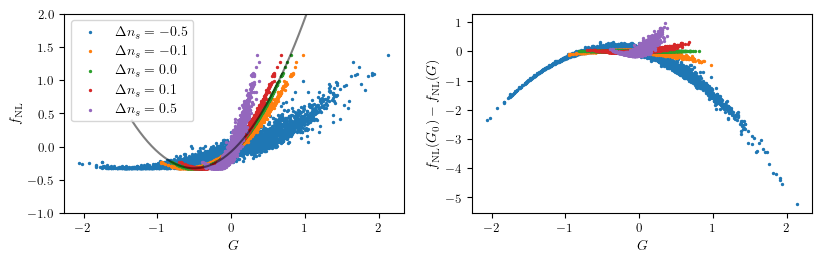

In [252]:
fig,axs = plt.subplots(ncols=2, figsize=(10,2.5))

for ns in [-0.5, -0.1, 0., 0.1, 0.5]:
    f_tilt = tilt_spectrum(fns, ns)
    axs[0].scatter(f_tilt[:10], f_ng[:10], s=2., label=r'$\Delta n_s = %.1f$' % ns)
    axs[1].scatter(f_tilt[:10], f_ng[:10] - f_nl(f_tilt[:10],alpha,var), s=2.)
    # This rescaling works for a highly blue tilted spectrum
    #sig_ = np.mean(np.std(f_tilt,axis=-1))
    #plt.plot(xv, xv + 0.05*xv**2/sig_**2)
    
axs[0].plot(xv, f_nl(xv,alpha,var), 'k', alpha=0.5)
axs[0].legend()
axs[0].set_ylim(-1.,2.)
axs[0].set_ylabel(r'$f_{\rm NL}$')
axs[0].set_xlabel(r'$G$')
axs[1].set_xlabel(r'$G$')
axs[1].set_ylabel(r'$f_{\rm NL}(G_0) - f_{\rm NL}(G)$')

From the above, we see that if we compare to the incorrect (but still Gaussian) underlying field, then some scatter around a perfect mapping $f_{\rm NL}(g)$ develops.

In addition, relative to the case of the correct underlying relationship, we see that the precise function defining the mapping has changed as well. For the specific case of (correlated) quadratic nonGaussianity considered here, it appears that we can largely account for this modified functional form by

$$ \hat{f}_{\rm NL} = \hat{G}(x) + 0.05\frac{\hat{G}^2(x)}{\sigma_G^2} $$

where $\sigma_g^2$ is the (real space) variance of the field $G$ with modified spectrum, instead of the variance of the correct underlying field $\sigma^2$ used to define the original mapping.

In [65]:
map_correlated_quadratic = lambda x,a : x + a*x**2

map_correlated_cubit = lambda x,a : x + a*x**3

map_tanh = lambda x,a : np.tanh(a*x)

Let's now explore how sensitive these results are to the parameter $\alpha$.

## Bumps in the Gaussian spectrum
Now, instead of assuming a power-law spectrum with incorrectly determined spectral tilt, we'll instead do something more interesting to the underlying Gaussian spectrum and insert a bump of power.

$$ \tilde{g}(k) = \tilde{g}_{0}(k)\sqrt{1 + Ae^{-(k-k_\star)^2/w^2}} $$

giving a modified power spectrum of

$$ P_G = P_{G_0}\left(1 + A^{-(k-k_\star)^2/w^2}\right) $$

In [253]:
def power_bump(f, amp, wid, k):
    nLat = f.shape[-1]
    
    fk = np.fft.rfft(f,axis=-1)
    kv = np.fft.rfftfreq(nLat)
    fk[:,1:] = fk[:,1:]*np.sqrt( 1. + amp*np.exp(-(kv[1:]-k)**2/wid**2) )
    
    return np.fft.irfft(fk, n=nLat, axis=-1)


### Adjusting amplitude of bump at fixed wavenumber and width

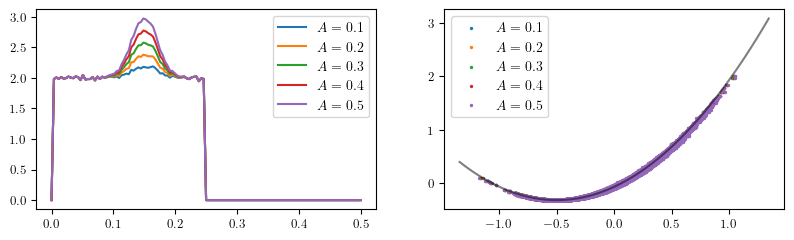

In [256]:
sz = 100

fig, axs = plt.subplots(ncols=2, figsize=(10,2.5))

for a in [0.1,0.2,0.3,0.4,0.5]:
    f_bump = power_bump(fns, a, 0.03, 0.15)
    fk_bump = np.fft.rfft(f_bump)
    
    axs[0].plot(kv,kv*np.mean(np.abs(fk_bump)**2,axis=0), label=r'$A = %.1f$' % a)
    axs[1].scatter(f_bump[:sz], f_ng[:sz], s=2., label=r'$A = %.1f$' % a)
    
axs[1].plot(xv, f_nl(xv,alpha,var),'k',alpha=0.5)
axs[0].legend()
axs[1].legend()


### Adjusting position of bump at fixed wavenumber and amplitude

Text(0.5, 0, '$k/k_{\\rm nyq}$')

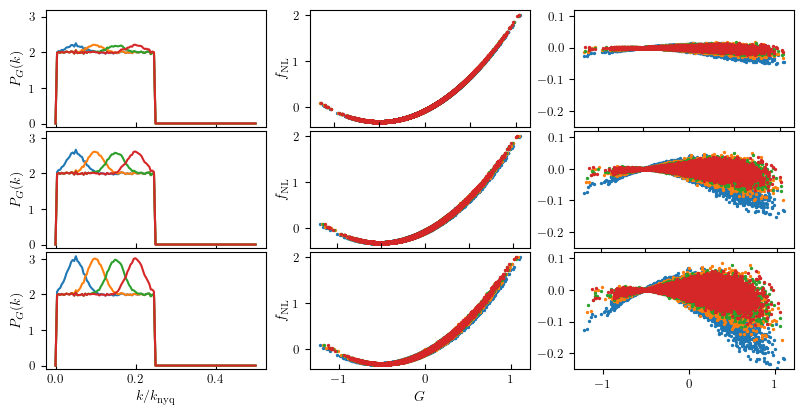

In [263]:
sz = 100

amps = [0.1,0.3,0.5]

fig, axs = plt.subplots(ncols=3, nrows=len(amps), figsize=(10,1.5*len(amps)),
                       gridspec_kw = {'hspace' : 0.03})
wid = 0.03

for i,amp in enumerate(amps):
    for k0 in [0.05, 0.1, 0.15, 0.2]:    
        f_bump = power_bump(fns, amp, wid, k0)
        fk_bump = np.fft.rfft(f_bump)
    
        axs[i][0].plot(kv,kv*np.mean(np.abs(fk_bump)**2,axis=0))
        axs[i][1].scatter(f_bump[:sz], f_ng[:sz], s=2.)
        axs[i][2].scatter(f_bump[:sz], f_ng[:sz]-f_nl(f_bump[:sz],alpha,var), s=2.)
        
        axs[i][0].tick_params(axis='x',direction='in')
        axs[i][1].tick_params(axis='x',direction='in')
        axs[i][0].set_ylim(-0.1,3.2)
        axs[i][2].set_ylim(-0.25,0.12)
        axs[i][0].set_ylabel(r'$P_{G}(k)$')
        axs[i][1].set_ylabel(r'$f_{\rm NL}$')
        
for a_ in axs[:-1]:
    a_[0].set_xticklabels([])
    a_[1].set_xticklabels([])
    
axs[-1][1].set_xlabel(r'$G$')
axs[-1][0].set_xlabel(r'$k/k_{\rm nyq}$')


### Adjusting width of bump at fixed position and amplitude

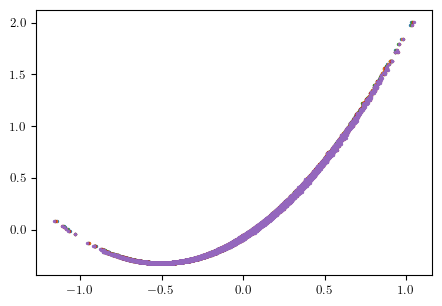

In [264]:
sz = 100

for w in [0.01, 0.02, 0.03, 0.04, 0.05]:
    f_bump = power_bump(fns[:sz], 0.2, w, 0.15)
    plt.scatter(f_bump, f_ng[:sz], s=2.)
    
plt.show()

## 2. Other Functional Forms of NonGaussianity

# II. Uncorrelated NonGaussianity
Now we explore uncorrelated nonGaussianity of the form
$$ f_{\rm NL} = f_{\rm G} + F_{\rm NL}(G) $$

where $f_{\rm G}$ is a Gaussian random field, and $G$ is a different Gaussian random field